<a href="https://colab.research.google.com/github/Naima-Yaqub/Network-Traffic-Anomaly-Detection-under-Limited-Labels-using-Machine-Learning-and-Deep-Learning/blob/main/Network_Traffic_Anomaly_Detection_under_Limited_Labels_using_Machine_Learning_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Traffic Anomaly Detection using ML & Deep Learning (NSL-KDD)

This notebook builds an end-to-end anomaly detection pipeline for network traffic.  
I have compared **supervised** baselines (when labels are available) with **unsupervised** and **deep unsupervised** methods that learn normal behavior and flag deviations.

**Why this matters:** In real deployments, attack labels are often incomplete or delayed, so robust anomaly detection needs to work under limited supervision.


## Step # 1:  Data Loading & Sanity Checks

Here I have uploaded NSL-KDD dataset and checked basic properties such as dataset size, label distribution and missing values to ensures the dataset is usable before building any models.

In [1]:
# Dataset: NSL-KDD (public CSV mirror)

!pip -q install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from pathlib import Path

# Downloading NSL-KDD files (KDDTrain+ and KDDTest+)
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv"
test_url  = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv"

train_path = data_dir / "KDDTrain+.csv"
test_path  = data_dir / "KDDTest+.csv"

if not train_path.exists():
    !wget -q -O "{train_path}" "{train_url}"
if not test_path.exists():
    !wget -q -O "{test_path}" "{test_url}"

col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label","difficulty"
]

# Loading
train_df = pd.read_csv(train_path, names=col_names)
test_df  = pd.read_csv(test_path,  names=col_names)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Quick sanity checks
print("\nTrain label distribution (top 10):")
print(train_df["label"].value_counts().head(10))

print("\nData types (sample):")
print(train_df.dtypes.head(12))

print("\nMissing values (train total):", train_df.isna().sum().sum())

# Data Preview
train_df.head()


Train shape: (125973, 43)
Test shape : (22543, 43)

Train label distribution (top 10):
label
normal         67343
neptune        41214
satan           3633
ipsweep         3599
portsweep       2931
smurf           2646
nmap            1493
back             956
teardrop         892
warezclient      890
Name: count, dtype: int64

Data types (sample):
duration              int64
protocol_type        object
service              object
flag                 object
src_bytes             int64
dst_bytes             int64
land                  int64
wrong_fragment        int64
urgent                int64
hot                   int64
num_failed_logins     int64
logged_in             int64
dtype: object

Missing values (train total): 0


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


The label distribution shows that the used dataset contains both **normal traffic** and multiple categories of **attacks**.  
For anomaly detection, it is converted into a **binary task**:
- `0` → normal traffic  
- `1` → attack/anomaly  
This binary framing helps with detecting 'anything abnormal' without getting into the attack type.

## Step # 2: Preprocessing & Train/Validation Split

The data is preprocessed to make it model-ready:
- One-hot encode categorical features (protocol/service/flag)
- Standardize numeric features
- Split into train/validation sets with stratification

Leakage is also avoid by fitting preprocessing **only on the training set**.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Droping 'difficulty' column (not useful for this case)
train_df2 = train_df.drop(columns=["difficulty"]).copy()
test_df2  = test_df.drop(columns=["difficulty"]).copy()

# Creating binary anomaly label: 0 = normal, 1 = attack
# Original labels have "normal" and multiple attack types such as neptune, smurf, etc.
train_df2["is_attack"] = (train_df2["label"] != "normal").astype(int)
test_df2["is_attack"]  = (test_df2["label"] != "normal").astype(int)

# For anomaly detection primarily 'is_attack' column is used.
# Features = all columns except label/is_attack
X = train_df2.drop(columns=["label", "is_attack"])
y = train_df2["is_attack"]

X_test_raw = test_df2.drop(columns=["label", "is_attack"])
y_test = test_df2["is_attack"]

print("Binary labels in TRAIN:", y.value_counts().to_dict())
print("Binary labels in TEST :", y_test.value_counts().to_dict())

# Identifying categorical vs numeric columns
cat_cols = ["protocol_type", "service", "flag"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("\nCategorical columns:", cat_cols)
print("Numeric columns count:", len(num_cols))

# Train/Val split -
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nSplit shapes:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train distribution:", y_train.value_counts(normalize=True).round(4).to_dict())
print("y_val distribution  :", y_val.value_counts(normalize=True).round(4).to_dict())

# Preprocessing pipeline
# - OneHotEncode categoricals for handling unknown categories from test/val safely
# - Standardize numeric features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# Fit on training only, transform train/val/test
X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test_raw)

print("\nAfter preprocessing:")
print("X_train_p shape:", X_train_p.shape)
print("X_val_p shape  :", X_val_p.shape)
print("X_test_p shape :", X_test_p.shape)

Binary labels in TRAIN: {0: 67343, 1: 58630}
Binary labels in TEST : {1: 12833, 0: 9710}

Categorical columns: ['protocol_type', 'service', 'flag']
Numeric columns count: 38

Split shapes:
X_train: (100778, 41) X_val: (25195, 41)
y_train distribution: {0: 0.5346, 1: 0.4654}
y_val distribution  : {0: 0.5346, 1: 0.4654}

After preprocessing:
X_train_p shape: (100778, 121)
X_val_p shape  : (25195, 121)
X_test_p shape : (22543, 121)


## Step # 3: Supervised Baselines (Upper Bound with Labels)

Before moving to anomaly detection, supervised baselines are trained:
- **Logistic Regression** (linear baseline)
- **Random Forest** (nonlinear baseline)

These serve as an *upper bound* because they assume labeled attacks are available during training.

=== Logistic Regression (Validation) ===
              precision    recall  f1-score   support

           0     0.9705    0.9782    0.9743     13469
           1     0.9747    0.9659    0.9703     11726

    accuracy                         0.9725     25195
   macro avg     0.9726    0.9720    0.9723     25195
weighted avg     0.9725    0.9725    0.9724     25195

ROC-AUC: 0.9963780671358508

=== Random Forest (Validation) ===
              precision    recall  f1-score   support

           0     0.9987    0.9996    0.9991     13469
           1     0.9996    0.9985    0.9990     11726

    accuracy                         0.9991     25195
   macro avg     0.9991    0.9990    0.9991     25195
weighted avg     0.9991    0.9991    0.9991     25195

ROC-AUC: 0.9999951278193638


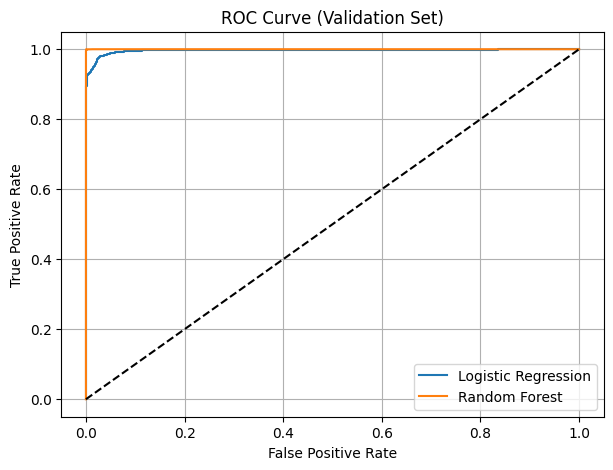

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# Logistic Regression
logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

logreg.fit(X_train_p, y_train)

y_val_pred_lr = logreg.predict(X_val_p)
y_val_prob_lr = logreg.predict_proba(X_val_p)[:, 1]

print("=== Logistic Regression (Validation) ===")
print(classification_report(y_val, y_val_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob_lr))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_p, y_train)

y_val_pred_rf = rf.predict(X_val_p)
y_val_prob_rf = rf.predict_proba(X_val_p)[:, 1]

print("\n=== Random Forest (Validation) ===")
print(classification_report(y_val, y_val_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob_rf))

# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_prob_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

### Supervised baseline results

The supervised models achieve very high performance, especially Random Forest.  
This shiows that the dataset is learnable and that strong separation is possible **when labels are available**.

However, presence of reliable lables in real time is not usually the case for network monitoring , so we move to **unsupervised anomaly detection trained only on normal traffic**.

## Step # 4 — Unsupervised Anomaly Detection (Label-Free)

Here anomaly detectors are trained using **only normal traffic** and evaluated  on mixed validation data.

This setup reflects realistic deployment scenarios:
- We usually know what "normal" looks like
- Attacks are rare, evolving or not labeled

Models:
- Isolation Forest (fast, lightweight)
- One-Class SVM (conservative boundary-based detector)

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Training only on normal traffic (label = 0)
X_train_normal = X_train_p[y_train == 0]

print("Normal samples used for training:", X_train_normal.shape[0])

# Ground truth for validation: convert to anomaly labels
# sklearn convention: 1 = normal, -1 = anomaly
y_val_anom = y_val.map({0: 1, 1: -1})

# Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_normal)

iso_pred_val = iso_forest.predict(X_val_p)
iso_score_val = -iso_forest.decision_function(X_val_p)

print("\n=== Isolation Forest (Validation) ===")
print(classification_report(y_val_anom, iso_pred_val, digits=4))
print("ROC-AUC:", roc_auc_score((y_val == 1).astype(int), iso_score_val))

# One-Class SVM
ocsvm = OneClassSVM(
    kernel="rbf",
    gamma="scale",
    nu=0.05
)

ocsvm.fit(X_train_normal)

ocsvm_pred_val = ocsvm.predict(X_val_p)
ocsvm_score_val = -ocsvm.decision_function(X_val_p)

print("\n=== One-Class SVM (Validation) ===")
print(classification_report(y_val_anom, ocsvm_pred_val, digits=4))
print("ROC-AUC:", roc_auc_score((y_val == 1).astype(int), ocsvm_score_val))

Normal samples used for training: 53874

=== Isolation Forest (Validation) ===
              precision    recall  f1-score   support

          -1     0.9544    0.8830    0.9173     11726
           1     0.9044    0.9632    0.9329     13469

    accuracy                         0.9259     25195
   macro avg     0.9294    0.9231    0.9251     25195
weighted avg     0.9276    0.9259    0.9256     25195

ROC-AUC: 0.9810401765650404

=== One-Class SVM (Validation) ===
              precision    recall  f1-score   support

          -1     0.9373    0.9168    0.9269     11726
           1     0.9289    0.9466    0.9377     13469

    accuracy                         0.9327     25195
   macro avg     0.9331    0.9317    0.9323     25195
weighted avg     0.9328    0.9327    0.9327     25195

ROC-AUC: 0.9525731236434587


### Unsupervised Results

Unsupervised models perform strongly but show a clear trade-off:
- Some methods miss more attacks (higher false negatives)
- Others raise more false alarms (higher false positives)

This is expected as without labels, the model is learning a boundary around *normal behavior* rather than learning explicit attack signatures.

In order to take care of this I have added a deep unsupervised method (LSTM Autoencoder) to capture more complex nonlinear structure.

## Step # 5: Deep Unsupervised Anomaly Detection (LSTM Autoencoder)

We now train an **LSTM Autoencoder** on normal traffic only.  
Instead of directly predicting attack vs normal, the model learns to **reconstruct normal samples**.

Core idea:
- Normal traffic → low reconstruction error  
- Attack traffic → higher reconstruction error  

We then choose a threshold from validation normal traffic to classify anomalies.

In [5]:
# STEP 5(a) : Preparing Data for LSTM Autoencoder

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Ensuring everything is NumPy arrays
X_train_norm_dense = np.asarray(X_train_normal)
X_val_dense = np.asarray(X_val_p)

# Reshaping for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train_norm_dense.reshape(
    X_train_norm_dense.shape[0], 1, X_train_norm_dense.shape[1]
)

X_val_lstm = X_val_dense.reshape(
    X_val_dense.shape[0], 1, X_val_dense.shape[1]
)

print("LSTM train shape:", X_train_lstm.shape)
print("LSTM val shape  :", X_val_lstm.shape)

LSTM train shape: (53874, 1, 121)
LSTM val shape  : (25195, 1, 121)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 121)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 121)         │         3,993 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,025 (125.10 KB)

 Trainable params: 32,025 (125.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2409 - val_loss: 0.2496
Epoch 2/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1545 - val_loss: 0.2083
Epoch 3/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1259 - val_loss: 0.1866
Epoch 4/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1108 - val_loss: 0.1745
Epoch 5/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1013 - val_loss: 0.1668
Epoch 6/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0945 - val_loss: 0.1609
Epoch 7/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0892 - val_loss: 0.1557
Epoch 8/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0849 - val_loss: 0.1506
Epoch 9/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0811 - val_loss: 0.1463
Epoch 10/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0778 - val_loss: 0.1424
Epoch 11/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0748 - val_loss: 0.1391
Epoch 12/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms

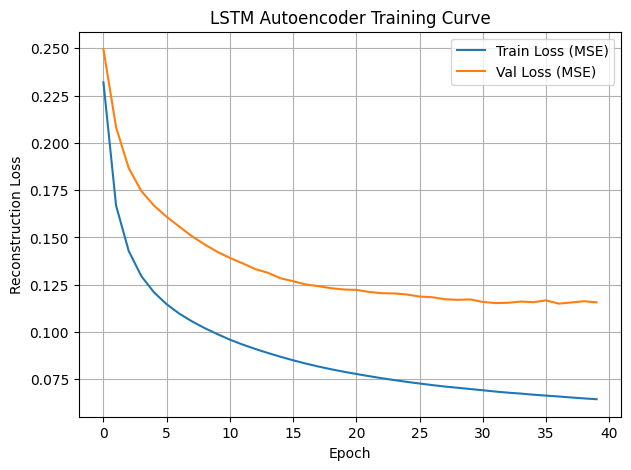

In [6]:
# STEP 5(b): LSTM Autoencoder (Build & Train)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

tf.random.set_seed(42)

timesteps = X_train_lstm.shape[1]
n_features = X_train_lstm.shape[2]

# Model architecture
# Encoder compresses input into latent vector
# Decoder reconstructs original input
latent_dim = 32

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(latent_dim, activation="tanh", return_sequences=False)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(latent_dim, activation="tanh", return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, outputs)

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Training
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_lstm, X_train_lstm,
    validation_data=(X_val_lstm, X_val_lstm),
    epochs=40,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# Plot loss curves
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("LSTM Autoencoder Training Curve")
plt.legend()
plt.grid(True)
plt.show()

The reconstruction loss decreases smoothly and stabilizes, which means the autoencoder has learned a consistent representation of normal traffic.  
Next, we need to translate the reconstruction loss into an anomaly score and evaluate detection performance.

Selected anomaly threshold (95th percentile): 0.011230

=== LSTM Autoencoder (Validation) ===
              precision    recall  f1-score   support

           0     0.9581    0.9500    0.9540     13469
           1     0.9431    0.9523    0.9477     11726

    accuracy                         0.9511     25195
   macro avg     0.9506    0.9511    0.9509     25195
weighted avg     0.9511    0.9511    0.9511     25195

ROC-AUC: 0.9859919139909867


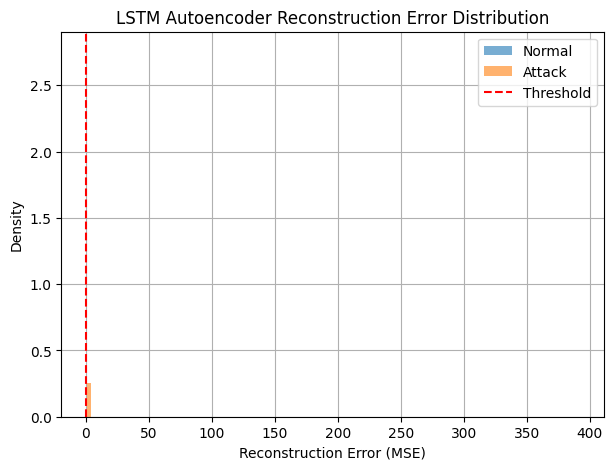

In [7]:
# STEP 5(c): LSTM Autoencoder Anomaly Detection

from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Reconstruction error (MSE per sample)
X_val_recon = autoencoder.predict(X_val_lstm, verbose=0)

val_mse = np.mean(
    np.square(X_val_lstm - X_val_recon),
    axis=(1, 2)
)

# Ground truth: 1 = attack, 0 = normal
y_val_binary = y_val.values

# Threshold selection (95th percentile of NORMAL traffic)
normal_val_mse = val_mse[y_val_binary == 0]
threshold = np.percentile(normal_val_mse, 95)

print(f"Selected anomaly threshold (95th percentile): {threshold:.6f}")

# Predictions
y_val_pred_lstm = (val_mse > threshold).astype(int)

print("\n=== LSTM Autoencoder (Validation) ===")
print(classification_report(y_val_binary, y_val_pred_lstm, digits=4))

roc_auc = roc_auc_score(y_val_binary, val_mse)
print("ROC-AUC:", roc_auc)

# Visualization: Reconstruction Error Distribution
plt.figure(figsize=(7,5))
plt.hist(normal_val_mse, bins=100, alpha=0.6, label="Normal", density=True)
plt.hist(val_mse[y_val_binary == 1], bins=100, alpha=0.6, label="Attack", density=True)
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density")
plt.title("LSTM Autoencoder Reconstruction Error Distribution")
plt.legend()
plt.grid(True)
plt.show()

### Reconstruction error separation

The error distribution shows normal samples clustered at low error, while attack samples tend to produce higher error.  
A threshold chosen from the **95th percentile of normal validation error** provides a practical, data-driven decision boundary.

This way we can avoid needing labeled attacks during training while still achieving strong detection performance.

## Step # 6: Final Comparison Across All Models

To compare models fairly, following are reported:
- Confusion matrices (normal vs attack outcomes)
- Precision–Recall curves (more informative for anomaly detection)
- A side-by-side metric table (Precision, Recall, F1, ROC-AUC)


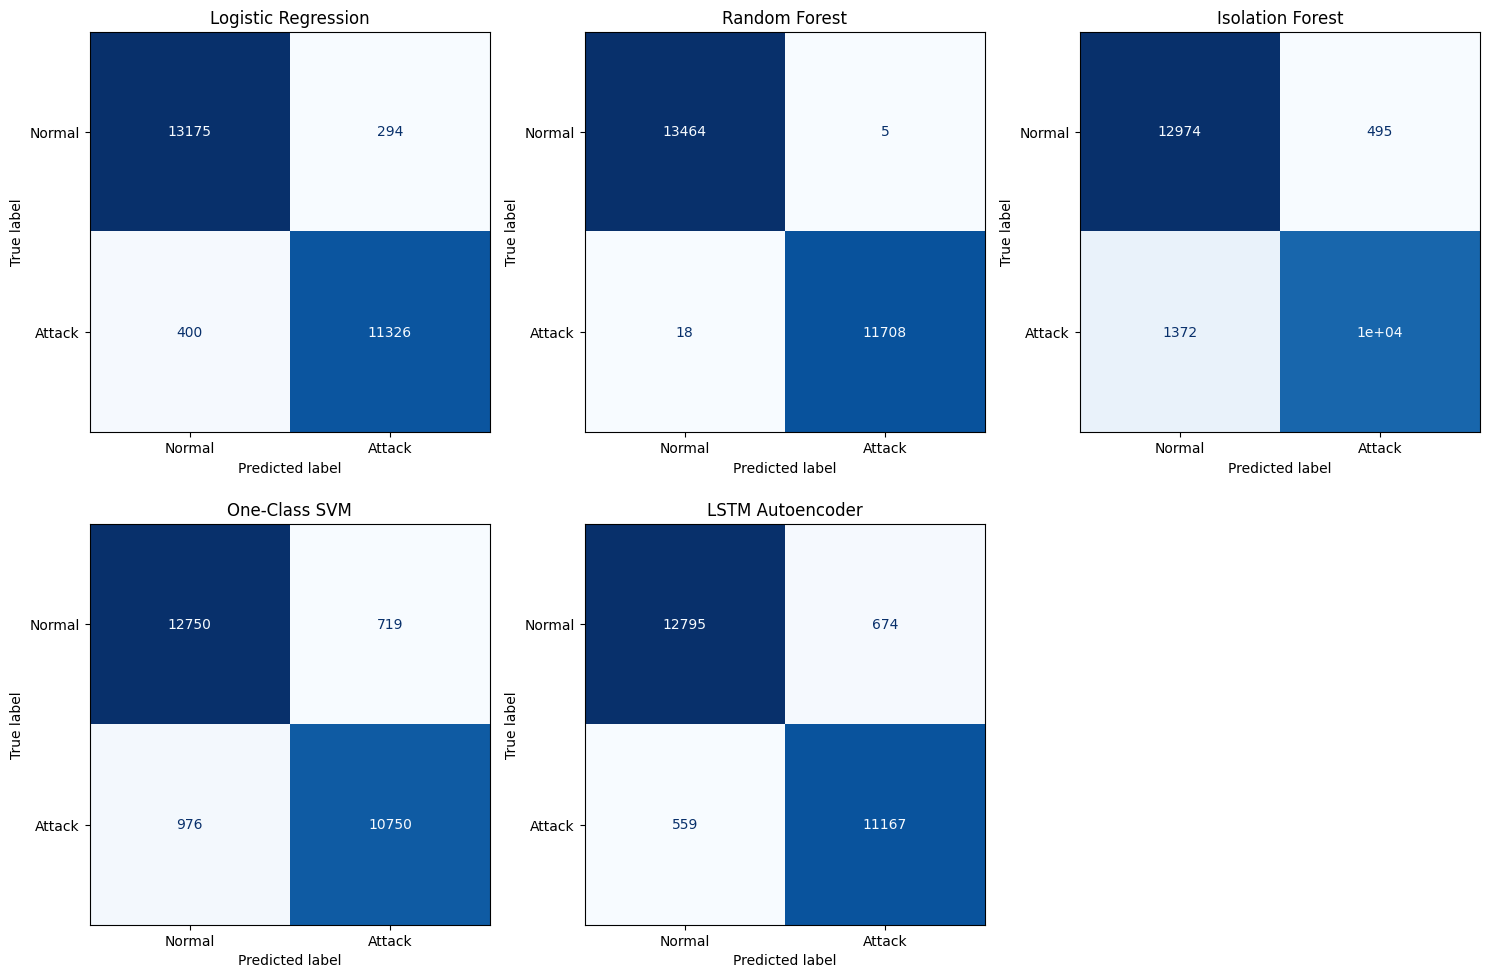

In [8]:
# STEP 6(a): Confusion Matrices

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models_preds = {
    "Logistic Regression": y_val_pred_lr,
    "Random Forest": y_val_pred_rf,
    "Isolation Forest": (iso_pred_val == -1).astype(int),
    "One-Class SVM": (ocsvm_pred_val == -1).astype(int),
    "LSTM Autoencoder": y_val_pred_lstm
}

plt.figure(figsize=(15,10))
for i, (name, preds) in enumerate(models_preds.items(), 1):
    plt.subplot(2, 3, i)
    cm = confusion_matrix(y_val_binary, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Attack"])
    disp.plot(cmap="Blues", ax=plt.gca(), colorbar=False)
    plt.title(name)

plt.tight_layout()
plt.show()

### Confusion matrix insights

Supervised models achieve near-perfect results because they directly learn from labeled attacks.  
Among unsupervised methods, deep autoencoders typically reduce missed attacks compared to classical methods, at the cost of higher model complexity.

The right choice depends on the application:
- If false negatives are costly → prioritize higher recall
- If false positives are costly → prioritize precision

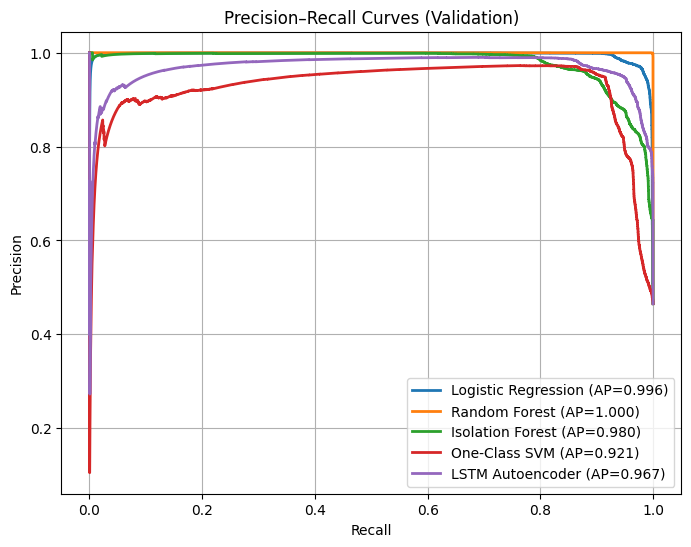

In [10]:
# STEP 6(b): Precision–Recall Curves (Validation Set)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

assert "y_val_binary" in globals(),
y_true = np.array(y_val_binary).astype(int)  # 1=attack, 0=normal
model_scores = {}

if "y_val_prob_lr" in globals():   model_scores["Logistic Regression"] = np.array(y_val_prob_lr)
if "y_val_prob_rf" in globals():   model_scores["Random Forest"] = np.array(y_val_prob_rf)
if "iso_score_val" in globals():   model_scores["Isolation Forest"] = np.array(iso_score_val)
if "ocsvm_score_val" in globals(): model_scores["One-Class SVM"] = np.array(ocsvm_score_val)
if "val_mse" in globals():         model_scores["LSTM Autoencoder"] = np.array(val_mse)

if len(model_scores) == 0:
    raise RuntimeError("No model scores found. Run the model evaluation cells first.")

# Ploting PR curves
plt.figure(figsize=(8, 6))
for name, scores in model_scores.items():
    precision, recall, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    plt.plot(recall, precision, linewidth=2, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Validation)")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
# STEP 6(c): Side-by-Side Metric Table

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

assert "y_val_binary" in globals(), "y_val_binary not found (must be 0=normal, 1=attack)"
y_true = np.array(y_val_binary).astype(int)

# PREDICTIONS
model_preds = {
    "Logistic Regression": np.array(y_val_pred_lr),
    "Random Forest": np.array(y_val_pred_rf),
    "Isolation Forest": (np.array(iso_pred_val) == -1).astype(int),
    "One-Class SVM": (np.array(ocsvm_pred_val) == -1).astype(int),
    "LSTM Autoencoder": np.array(y_val_pred_lstm)
}

# SCORES
model_scores = {
    "Logistic Regression": np.array(y_val_prob_lr),
    "Random Forest": np.array(y_val_prob_rf),
    "Isolation Forest": np.array(iso_score_val),
    "One-Class SVM": np.array(ocsvm_score_val),
    "LSTM Autoencoder": np.array(val_mse)
}

rows = []

for model in model_preds:
    y_pred = model_preds[model]
    y_score = model_scores[model]

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    roc_auc  = roc_auc_score(y_true, y_score)

    rows.append([model, precision, recall, f1, roc_auc])

metrics_df = pd.DataFrame(
    rows,
    columns=["Model", "Precision", "Recall", "F1-score", "ROC-AUC"]
).sort_values(by="F1-score", ascending=False).reset_index(drop=True)

metrics_df


,Model,Precision,Recall,F1-score,ROC-AUC
0,Random Forest,0.999573,0.998465,0.999019,0.999995
1,Logistic Regression,0.974699,0.965888,0.970273,0.996378
2,LSTM Autoencoder,0.943079,0.952328,0.947681,0.985992
3,One-Class SVM,0.937309,0.916766,0.926924,0.952573
4,Isolation Forest,0.954374,0.882995,0.917298,0.981040


The Precision–Recall curves and the metric table show clear differences between the models. Random Forest performs the best overall, maintaining very high precision and recall across almost the entire range. This means it correctly detects nearly all attacks while producing very few false alarms. Logistic Regression also performs strongly, with only a small drop in performance compared to Random Forest.

Among the unsupervised models, the LSTM autoencoder gives the best results. It is able to detect most attacks while keeping a good balance between precision and recall, which is visible in both the metric table and its Precision–Recall curve. Isolation Forest is more conservative while its precision is high, its lower recall shows that it misses more attacks. One-Class SVM performs the weakest, with a noticeable drop in precision as recall increases, leading to more false positives.

Overall, the results show that supervised models achieve the highest performance, but the LSTM autoencoder is a strong alternative when labelled data is not available.

## Conclusion

This notebook shows that:
- Supervised models provide an upper bound when labels exist.
- Classical unsupervised methods are lightweight and practical but may miss more attacks.
- The LSTM Autoencoder achieves strong detection without requiring labeled attacks, making it suitable for realistic intelligent network monitoring.

In short: **deep unsupervised learning offers a strong balance between practicality and performance for anomaly detection in networked systems.**